# Lab: SVD - PCA

## Imports

In [1]:
import numpy as np
from numpy import linalg as LA
from numpy import array
from numpy import random

import math  
import pandas as pd

from scipy.linalg import svd

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt
import seaborn as sns

import time
from datetime import datetime

from adjustText import adjust_text

## Exercice 1. (Linear algebra)

In [2]:
SCALAR = 10e-5
MU, SIGMA = 0, 5

In [3]:
def generate_matrices(N, P):
    X = np.random.normal(loc=MU, scale=math.sqrt(SIGMA), size=(N, P))
    y = np.random.uniform(low=-1, high=1, size=(N, 1))
    return X, y

In [4]:
def compute_left(X, y):
    return X.T.dot(np.linalg.solve(X.dot(X.T) + SCALAR * np.eye(X.shape[0]), y))

In [5]:
def compute_right(X, y):
    return np.linalg.solve(X.T.dot(X) + SCALAR * np.eye(X.shape[1]), X.T).dot(y)

In [6]:
def check_equation(N, P):
    X, y = generate_matrices(N, P)
    left, right = compute_left(X, y), compute_right(X, y)
    if np.allclose(left, right):
        print('The equation holds: the two systems are equal.')
    else:
        print('The equation does not hold: the two systems are not equal.')

In [7]:
def compute_time_in_ms(function, args):
    start = datetime.now()
    function(*args)
    end = datetime.now()
    time = (start - end).total_seconds() * 1000.0
    return time

### Question (1)

#### Case N = 100, P = 2000

In [8]:
N, P = 100, 2000

In [9]:
print(f'Case N = {N}, P = {P}')
check_equation(N, P)

Case N = 100, P = 2000
The equation holds: the two systems are equal.


#### Case N = 2000, P = 100

In [10]:
N, P = 2000, 100

In [11]:
print(f'Case N = {N}, P = {P}')
check_equation(N, P)

Case N = 2000, P = 100
The equation holds: the two systems are equal.


### Question (2)

In [12]:
def heat_map(function):
    M = np.ndarray(shape=(20, 20))
    for n in range(M.shape[0]):
        for p in range(M.shape[1]):
            X, y = generate_matrices(n * 100, p * 100)
            M[n][p] = compute_time_in_ms(compute_left, (X, y))
    ax = sns.heatmap(M, cbar=False)
    ax.set(xlabel='N', ylabel='P');

#### Left hand side formulation

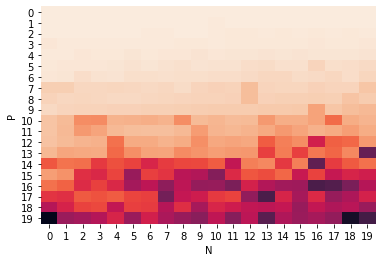

In [13]:
heat_map(compute_left)

#### Right hand side formulation

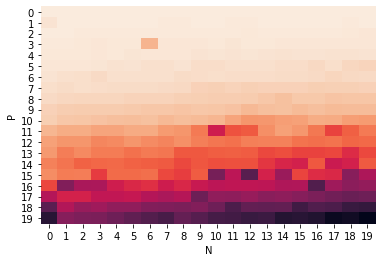

In [14]:
heat_map(compute_right)

## Exercice 2. (Random matrix spectrum)

### Question (3)

The 3 non-Gaussian probability distributions with mean 0 and var 2 we choose are the following:
- A **uniform** distribution over [-sqrt(6), sqrt(6)] (with sqrt(6) ~ 2.45)
- A **Laplace** distribution with mean mu=0 and b=1
- A **Logistic** distribution with mean mu=0 and s=sqrt(6)/pi

In [15]:
def generate(n, p, distribution):
    if distribution == "uniform":
        return np.random.uniform(-math.sqrt(6), math.sqrt(6), (n, p))
    elif distribution == "laplace":
        return np.random.laplace(0, 1, (n, p))
    elif distribution == "logistic":
        return np.random.logistic(0, math.sqrt(6)/math.pi, (n,p))
    else:
        return "Choose distribution among the following: 'uniform', 'laplace', or 'logistic'."

### Question (4)

In [16]:
DISTRIBUTIONS = ['uniform', 'laplace', 'logistic']
N = 1000
P = [200, 500, 1000, 2000]

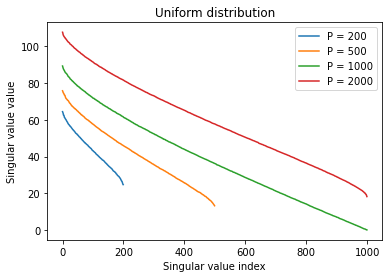

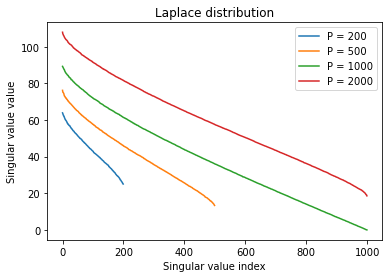

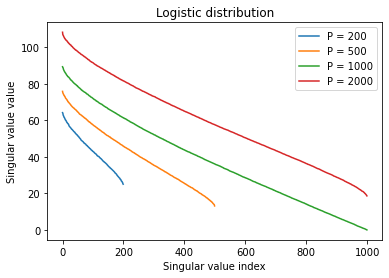

In [17]:
for distribution in DISTRIBUTIONS:
    plt.figure()
    for p in P:
        X = generate(N, p, distribution)
        S = LA.svd(X, compute_uv=False)
        plt.plot(S, label=f'P = {p}')
        plt.xlabel('Singular value index')
        plt.ylabel('Singular value value')
        plt.title(f'{distribution.capitalize()} distribution')
        plt.legend()
plt.show()

### Question (5)

/Users/mathisbatoul/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathisbatoul/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathisbatoul/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


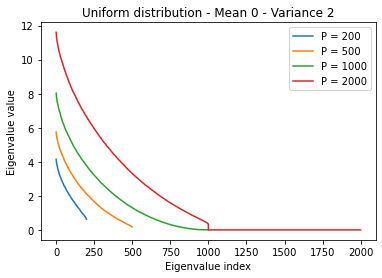

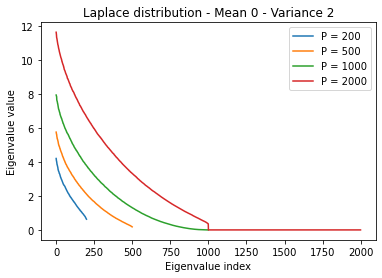

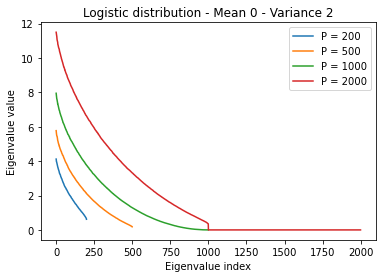

In [18]:
for distribution in DISTRIBUTIONS:
    plt.figure()
    for p in P:
        X = generate(N, p, distribution)
        X = X.T.dot(X) / N
        W = LA.eig(X)[0]
        W[::-1].sort()
        plt.plot(W, label=f'P = {p}')
        plt.xlabel('Eigenvalue index')
        plt.ylabel('Eigenvalue value')
        plt.title(f'{distribution.capitalize()} distribution - Mean 0 - Variance 2')
        plt.legend()
plt.show()

For all three distributions, we get the same plot.
- The # of non negative eigenvalues = the # of columns.
- The values of those eigenvalues have a greater maximum as p increases, and all tend toward 0
- The singular values decrease in a quadratic fashion

## Exercice 3. (Power method)

### Question (6)

In [19]:
class PowerIterator:
    def __init__(self):
        self.iterations_u = []
        self.iterations_v = []
        self.final_u = None
        self.final_v = None
    
    def perform(self, X, u, v, n_iter):
        for _ in range(n_iter):
            u = X.dot(v) 
            v = X.T.dot(u)
            v = v / LA.norm(v)
            u = u / LA.norm(u)
            self.iterations_u.append(u)
            self.iterations_v.append(v)
        self.final_u, self.final_v = u, v
        self.iterations_u, self.iterations_v = np.absolute(self.iterations_u), np.absolute(self.iterations_v)

### Question (7)

In [20]:
N, P = 100, 2000
MU, SIGMA = 0, 5
X = np.random.normal(loc=MU, scale=math.sqrt(SIGMA), size=(N, P))
u, v = np.random.rand(X.shape[0], 1), np.random.rand(X.shape[1], 1)
n_iter = 250

In [21]:
power_iterator = PowerIterator()
power_iterator.perform(X, u, v, n_iter)
iter_u, iter_v = power_iterator.iterations_u, power_iterator.iterations_v

In [22]:
U, _, V_transpose = LA.svd(X)

In [23]:
limit_u = U[:, 0].reshape(N, 1)
limit_u = np.full(shape=(n_iter, N, 1), fill_value=limit_u)
limit_u = np.absolute(limit_u)
error_u = iter_u - limit_u
error_u = LA.norm(error_u, axis=1)

In [24]:
limit_v = V_transpose.T[:, 0].reshape(P, 1)
limit_v = np.full(shape=(n_iter, P, 1), fill_value=limit_v)
limit_v = np.absolute(limit_v)
error_v = iter_v - limit_v
error_v = LA.norm(error_v, axis=1)

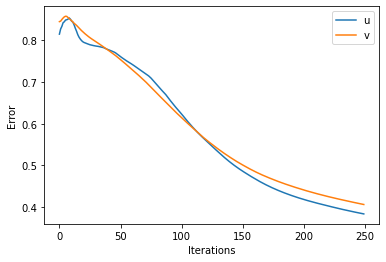

In [25]:
plt.plot(error_u, label='u')
plt.plot(error_v, label='v')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

### Question (8)

We tried to choose u, v orthogonal to the limit vectors but the convergence was still valid

### Question (9)

In [26]:
u, v = power_iterator.final_u, power_iterator.final_v

#### Approximation of sigma

In [27]:
# First way
s = X.dot(v) / u
print(s[0])

# Second way
s = X.T.dot(u) / v
print(s[0])

[120.50291963]
[120.47401708]


#### Actual value of sigma

In [28]:
_, S, _ = LA.svd(X)
print(S[0])

120.49818690386536


#### Remark

On note que le nombre d'itérations `n_iter` doit être suffisamment élevé pour obtenir une approximation correcte.

Pour ce faire, on détermine `n_iter` en utilisant les représentations graphiques obtenu à la question 7.

Pour améliorer cet algorithme on chercherait à déterminer `n_iter` automatiquement.

### Question (10)

## Exercice 4. (PCA)

### Question (11)

In [59]:
df = pd.read_csv('http://josephsalmon.eu/enseignement/TELECOM/SD204/defra_consumption.csv', sep=';')
df.rename({'Unnamed: 0': 'Category'}, axis=1, inplace=True)

### Question (12)

In [61]:
num_cols = [c for c in df.columns if df[c].dtype.kind in ["i", "f"]]

df[num_cols] = preprocessing.scale(df[num_cols]) 

X = df.iloc[:,1:].to_numpy()

### Question (13)

In [31]:
CATEGORIES = df['Category']

In [32]:
def draw_pca_2d_scatter(df, title):
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x="PC1", y="PC2", s=30)
    plt.xlabel("PC1", fontsize = 20)
    plt.ylabel("PC2", fontsize = 20)
    plt.title(title)
    texts = [plt.text(*df.iloc[i], CATEGORIES[i]) for i in range(len(df))]

In [33]:
def draw_pca_3d_scatter(df, title):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title("3 dimensions")
    ax.view_init(15, 260)
    plt.title(title)
    for i in range(len(df)):
        ax.scatter(*df.iloc[i], color='b')
        ax.text(*df.iloc[i], CATEGORIES[i], color='k')

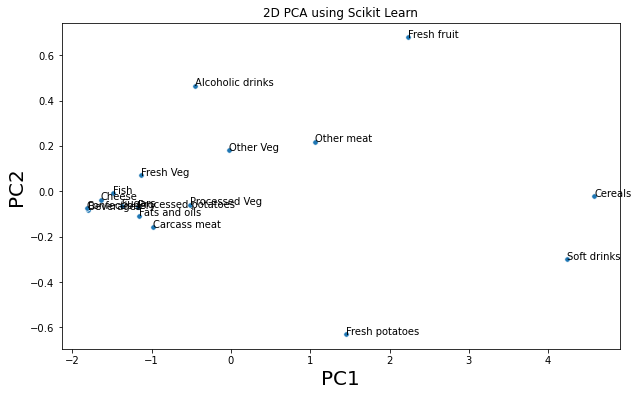

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

pca_2d_df = pd.DataFrame(data = pca_2d, columns = ['PC1', 'PC2'])

draw_pca_2d_scatter(pca_2d_df, "2D PCA using Scikit Learn")

Improvement: Add labels using AdjustText
Signs are opposite

### Question (14)

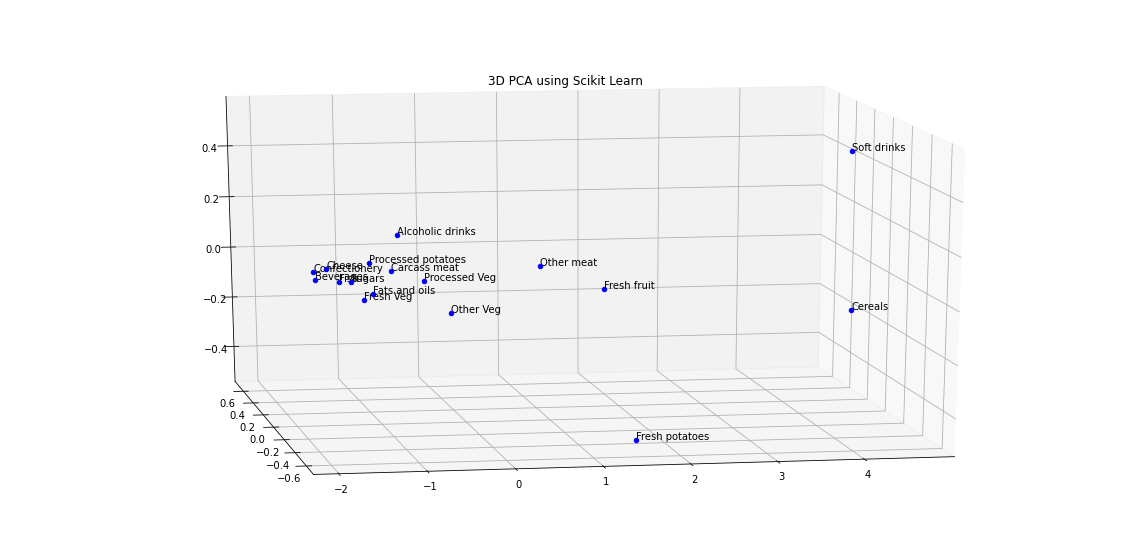

In [35]:
pca = PCA(n_components=3)
pca_3d = pca.fit_transform(X)

pca_3d_df = pd.DataFrame(data = pca_3d, columns = ['PC1', 'PC2', 'PC3'])

draw_pca_3d_scatter(pca_3d_df, '3D PCA using Scikit Learn')

### Question (15)

### (A)

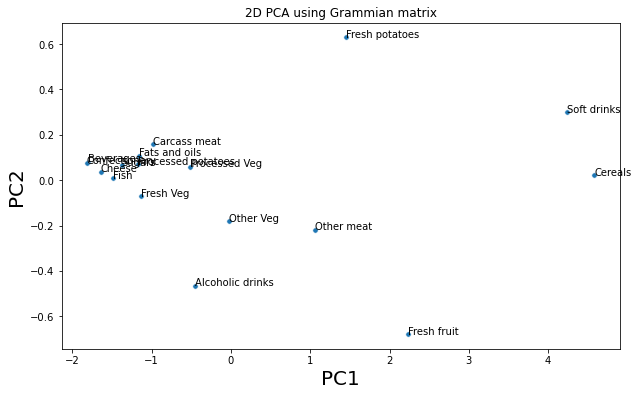

In [36]:
# 2 dimensions
start_2d_gram = time.time()

eigen_values, eigen_vectors = LA.eig(X.T @ X)

idx = eigen_values.argsort()[::-1]   
eigen_vectors = eigen_vectors[:,idx] 

P = np.array(eigen_vectors)
M = X @ P[:, :2]

pca_2d_gram_df = pd.DataFrame(data = M, columns = ['PC1', 'PC2'])

time_2d_gram = time.time() - start_2d_gram

draw_pca_2d_scatter(pca_2d_gram_df, '2D PCA using Grammian matrix')

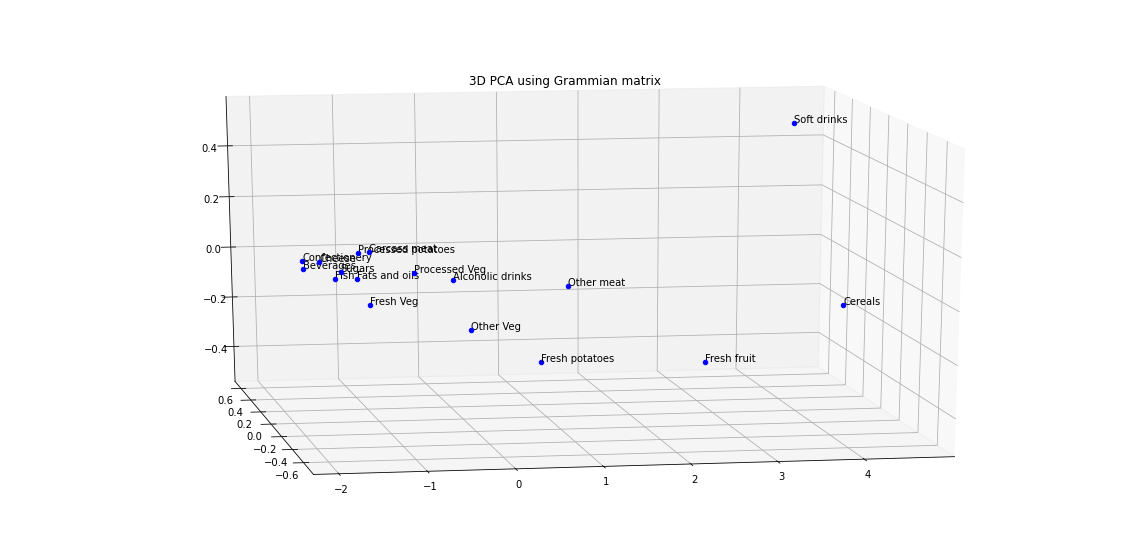

In [37]:
# 3 dimensions
start_3d_gram = time.time()

eigen_values, eigen_vectors = LA.eig(X.T @ X)

idx = eigen_values.argsort()[::-1]   
eigen_vectors = eigen_vectors[:,idx]

P = np.array(eigen_vectors)
M = X @ P[:, :3]

pca_3d_gram_df = pd.DataFrame(data = M
                     , columns = ['PC1', 'PC2', 'PC3'])

time_3d_gram = time.time() - start_3d_gram

draw_pca_3d_scatter(pca_3d_gram_df, '3D PCA using Grammian matrix')

### (B)

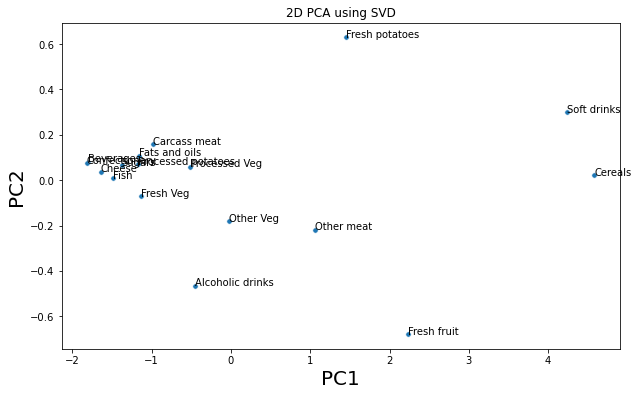

In [38]:
# 2 dimensions
start_2d_svd = time.time()

u, s, vh = np.linalg.svd(X, full_matrices=False)
V = vh.T

M = X @ V[:, :2]
pca_2d_svd_df = pd.DataFrame(data = M
             , columns = ['PC1', 'PC2'])

time_2d_svd = time.time() - start_2d_svd

draw_pca_2d_scatter(pca_2d_svd_df, '2D PCA using SVD')

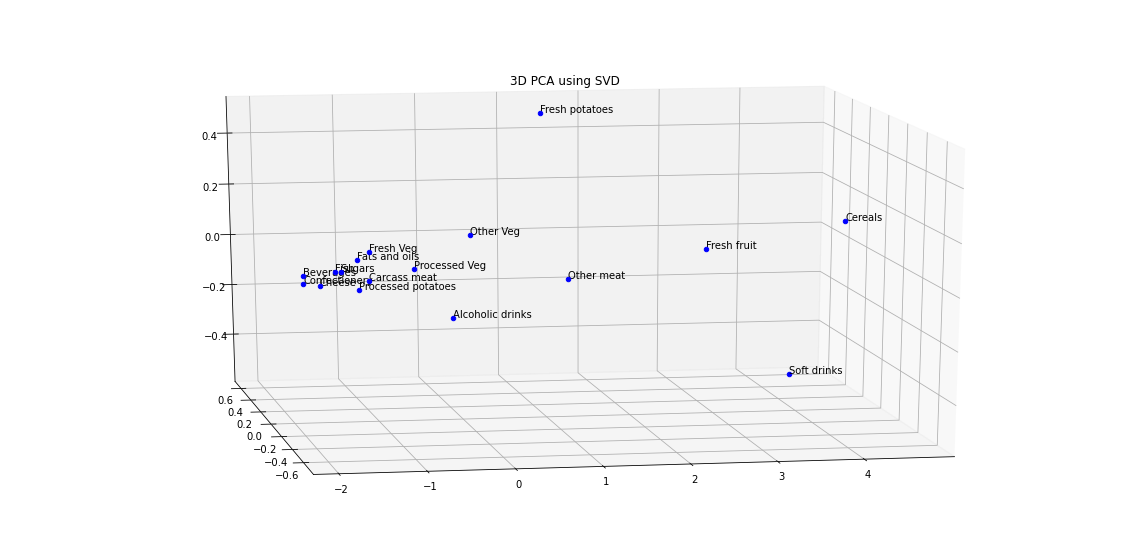

In [39]:
# 3 dimensions
start_3d_svd = time.time()

u, s, vh = np.linalg.svd(X, full_matrices=False)
V = vh.T

M = X @ V[:, :3]
pca_3d_svd_df = pd.DataFrame(data = M
                     , columns = ['PC1', 'PC2', 'PC3'])

time_3d_svd = time.time() - start_3d_svd

draw_pca_3d_scatter(pca_3d_svd_df, '3D PCA using SVD')

### (C)

In [40]:
print("For dimension = 2, the time elapsed with method 1 (eigenvectors of X.T @ X) is %.5f and with method 2 (right singular vectors of X) is %.5fs." % (time_2d_gram, time_2d_svd))
print("For dimension = 3, the time elapsed with method 1 (eigenvectors of X.T @ X) is %.5f and with method 2 (right singular vectors of X) is %.5fs." % (time_3d_gram, time_3d_svd))

For dimension = 2, the time elapsed with method 1 (eigenvectors of X.T @ X) is 0.00067 and with method 2 (right singular vectors of X) is 0.00059s.
For dimension = 3, the time elapsed with method 1 (eigenvectors of X.T @ X) is 0.00074 and with method 2 (right singular vectors of X) is 0.00054s.


## Exercice 5. (Analysis of the auto-mpg dataset)

### Question (16)

Importing the data

In [41]:
names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
df = pd.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True, names=names)

Dropping 'car name'

In [42]:
df.drop('car name', axis=1, inplace=True)

Looking for missing values

We look at the datatypes to check if there is string encoding for NaNs.

In [43]:
df.dtypes

mpg             float64
cylinders       float64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year      float64
origin          float64
dtype: object

Since all columns have dtype float64, we there is no string encoding for NaNs. <br>
NaNs could therefore be encoded with floats (e.g. -1, or 0, or 999...), so we use df.describe to spot those values.

In [44]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000,406.000000,406.000000
mean,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704,75.921182,1.568966
std,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359,3.748737,0.797479
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000,73.000000,1.000000
50%,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


We cannot see any unusual numerical value (e.g. negative values or positive outliers such as 999). <br>
Therefore, we should identify NaNs with the traditional df.isna()

In [45]:
df.isna().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [46]:
df.dropna(inplace=True)
df.isna().sum()
df.reset_index(drop=True, inplace=True)

### Question (17)

Two methods are possible. 1) pd.get_dummies 2) Scikit Learn OneHotEncoder

In [47]:
# Before employing either method, we add the country info to the df
df['origin'].replace([1,2,3],['USA','Europe', 'Japan'],inplace=True)

In [48]:
# 1st solution using pd.get_dummies
df = pd.concat([df,pd.get_dummies(df['origin'],prefix='country')]
               ,axis=1).drop(['origin'],axis=1)
# We can use drop_first=True to drop one dim

In [49]:
# 2nd solution using Sklearn OneHotEncoder
''' enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['origin']]).toarray())
enc_df.columns = enc.get_feature_names(['origin'])
df = df.join(enc_df)
df.drop('origin', axis=1, inplace=True)
'''

" enc = OneHotEncoder(handle_unknown='ignore')\nenc_df = pd.DataFrame(enc.fit_transform(df[['origin']]).toarray())\nenc_df.columns = enc.get_feature_names(['origin'])\ndf = df.join(enc_df)\ndf.drop('origin', axis=1, inplace=True)\n"

### Question (18)

In [50]:
df2 = df.drop_duplicates('model year').sample(9).reset_index(drop=True)

In [51]:
# Multiple linear regression with Scikit learn
X = df2.drop('mpg',axis=1)
y = df2.mpg

reg = LinearRegression().fit(X, y)

theta_hat = reg.coef_
intercept = reg.intercept_
y_hat = X @ theta_hat + intercept 

print('theta_hat :\n' + str(np.around(theta_hat, decimals=2)) + '\n' +
     'intercept :\n' + str(np.around(intercept, decimals=2)) + '\n' +
     'y_hat :\n' + str(np.around(y_hat, decimals=2)))

theta_hat :
[ 4.19  0.11 -0.05 -0.03 -0.55  0.5   4.43 -3.21 -1.22]
intercept :
42.29
y_hat :
0    31.5
1    27.2
2    20.0
3    28.0
4    27.0
5    21.5
6    24.0
7    13.0
8    19.0
dtype: float64


Each time we change the initial 9-row sample, we see that the weights are different - we even sometimes get illogical weights (e.g. a positive weight for the "weight" feature, which means that the heavier the car, the higher the mpg, (and the less the car "consumes" fuel)). <br>
We can see that the r2 score is 1 (y_hat = y), wich might show that we are "overfitting" the training set. <br>
Therefore, we cannot safely extrapolate those weights to new data because our training set is too small.

### Question (19)

In [52]:
X = df.drop('mpg',axis=1).values
y = df.mpg 

pipeline = Pipeline(steps=[('scaler', StandardScaler(copy=False)), ('regression', LinearRegression())])
pipeline.fit(X, y)

reg = pipeline.named_steps['regression']
theta_hat = reg.coef_
intercept = reg.intercept_
y_hat = X @ theta_hat + intercept 

print('theta_hat :\n' + str(np.around(theta_hat, decimals=2)) + '\n' +
     'intercept :\n' + str(np.around(intercept, decimals=2)) + '\n' +
     'y_hat :\n' + str(np.around(y_hat, decimals=2)))

theta_hat :
[-0.83  2.51 -0.7  -5.69  0.22  2.86  0.41  0.52 -0.75]
intercept :
23.45
y_hat :
[14.95 14.04 15.23 14.99 14.9  10.87 10.9  10.9  10.44 13.25 15.49 14.18
 14.9  19.42 23.58 18.73 19.12 20.66 24.91 27.91 21.62 22.88 23.32 23.95
 20.05  7.38  8.07  7.99  6.01 25.69 23.01 25.25 21.37 15.91 17.34 17.74
 17.18 11.39 10.66 12.12 11.74  6.87  8.9   6.16 19.65 22.65 17.62 18.75
 22.83 25.89 26.13 25.9  28.23 29.18 28.32 24.67 25.81 23.99 26.74 23.14
 23.76 11.73 12.01 12.29 13.03 14.9  10.36 10.51 10.72 11.53 24.72 13.51
 12.68 11.22 12.72 20.99 24.76 21.51 26.44 22.59 25.53 24.33 23.59 26.82
 13.58 15.68 14.87 13.62 15.39  9.22 12.71 12.15 12.46 10.59  9.32 15.53
 19.68 19.43 21.08 21.26 20.63 29.5   9.29  9.47 10.19 10.77 22.05 26.6
 24.29 25.88 27.01 24.15 22.12 26.18 14.24 12.3  29.19 27.6  24.3  22.29
 17.81 23.6  22.44 16.25 20.12 22.15 19.74 29.53 23.92 30.3  23.87 16.76
 17.85 17.15 13.64 10.91 11.69 10.47 12.85 27.47 28.95 26.84 31.56 29.38
 25.27 28.09 27.67 26.04 26.52 

In [53]:
print("The r2 score is %.2f" % reg.score(X,y))

The r2 score is 0.82


We get r2 = 0.82, i.e. 82% of the var of the mpg can be explained by our weights. <br>
Weight is the most important feature. If the columns were not normalized, this would
not make sense because the scale of weight is much higher than the other features
and we would suspect the influence of weight to be overestimated. <br>
Here, having scaled the features, we can confidently say that weight is an
important features, intependently of the range of values it takes.

### Question (20)

In [54]:
r = y - y_hat
r_dot_prod = LA.norm(r)**2

yn_bar = np.mean(y)
yn_bar_vect = yn_bar * np.ones(len(y))

left = LA.norm(y - yn_bar_vect)**2
right = r_dot_prod + LA.norm(y_hat - yn_bar_vect)**2
print(left, right)
np.isclose(left, right)

23818.99346938775 23818.993469387744


True

### Question (21)

In [55]:
X_test = pd.DataFrame(np.array([[6, 225, 100, 3233, 15.4, 117, 0, 0, 1]]), 
                      columns=['cylinders', 'displacement', 'horsepower', 'weight',
                   'acceleration', 'model year', 'country_Europe', 'country_Japan', 'country_USA'])
X_test

,cylinders,displacement,horsepower,weight,acceleration,model year,country_Europe,country_Japan,country_USA
0,6.0,225.0,100.0,3233.0,15.4,117.0,0.0,0.0,1.0


In [56]:
print("The prediction for this car is %.2f" % pipeline.predict(X_test))

The prediction for this car is 53.12


In [57]:
# Double checking the result
y_hat = X_test.values @ theta_hat + intercept
print("This matches the manual computation %.2f" % y_hat)

This matches the manual computation 53.12


In [58]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,country_Europe,country_Japan,country_USA
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.173469,0.201531,0.625000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.379136,0.401656,0.484742
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000
